In [1]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../../')

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import numpy as np
import Phys
import mendeleev
# physical constants in cgs units
constants = Phys.ReadPhys()
import importlib
from SpecWizard_Input import ReadData

import SpecWizard_BuildInput
SpecWizard_BuildInput = importlib.reload(SpecWizard_BuildInput)
from SpecWizard_BuildInput import Build_Input

import SpecWizard_ProjectData
SpecWizard_ProjectData = importlib.reload(SpecWizard_ProjectData)
from SpecWizard_ProjectData import SightLineProjection

import SpecWizard_ComputeOpticaldepth
SpecWizard_ComputeOpticaldepth = importlib.reload(SpecWizard_ComputeOpticaldepth)
from SpecWizard_ComputeOpticaldepth import ComputeOpticaldepth
from SpecWizard_Atomfile import Atomfile

This class defines the B-spline kernel of Monaghan and Lattanzio, as used in Gadget-2


In [4]:
import SimulationInputKeys

In [14]:
SimulationInputKeys.get_simkeys(sim_name='colibre')['snapshot']['elementnames']

['Hydrogen',
 'Helium',
 'Carbon',
 'Nitrogen',
 'Oxygen',
 'Neon',
 'Magnesium',
 'Silicon',
 'Iron',
 'Europium']

In [2]:
BI     = Build_Input()
Wizard = BI.read_from_yml("Wizard.yml")

Warning! SightLength NOT found. Setting default value: 1


In [13]:
Wizard['file_type']['sim_type']

'colibre'

In [23]:
for ion in Wizard['ionparams']['ions-available']:
    if ' ' in ion:
        seperate = ion.split(" ")
        el_short = seperate[0]
        print(getattr(mendeleev,el_short).name,ion)
#        print("yes")

Oxygen O VIII
Silicon Si VI
Hydrogen H I
Silicon Si V
Oxygen O IV
Oxygen O VII
Helium He III
Carbon C III
Carbon C I
Oxygen O II
Silicon Si VII
Oxygen O I
Carbon C VI
Oxygen O III
Silicon Si III
Silicon Si IV
Carbon C II
Silicon Si X
Oxygen O V
Oxygen O VI
Silicon Si IX
Silicon Si XI
Helium He II
Silicon Si XIII
Carbon C IV
Carbon C V
Silicon Si II
Hydrogen H II
Silicon Si XII
Silicon Si VIII
Silicon Si I


In [4]:
snapshot  = ReadData(wizard = Wizard)
particles = snapshot.read_particles()  


We divide Swift's smoothing length by 0.362 to convert from FWHM to extent of finite support


In [5]:
particles['Particles']['Densities']['Value']

array([0.39324418, 0.32536572, 0.4025954 , ..., 0.19837767, 0.23200513,
       0.1882808 ], dtype=float32)

(0.0, 35.0)

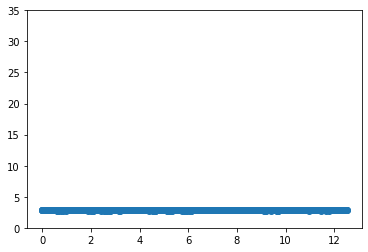

In [6]:
plt.scatter(particles['Particles']['Positions']['Value'][:,2],particles['Particles']['Positions']['Value'][:,1])
plt.ylim(0,35)

In [7]:
sightlineprojection  = SightLineProjection(Wizard)
projected_LOS        = sightlineprojection.ProjectData(particles)

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [68]:
projected_LOS['Mass-weighted']

{'Densities': {'Value': array([0.59236249, 0.551737  , 0.52367112, ..., 0.71677636, 0.6878547 ,
         0.64208499]),
  'Info': {'CGSConversionFactor': 6.769911178294543e-31,
   'VarDescription': 'Ion mass-densities',
   'aexp-scale-exponent': -3.0,
   'h-scale-exponent': 2.0}},
 'Velocities': {'Value': array([-237.82270317, -237.68392985, -237.4068967 , ..., -238.28781882,
         -238.05849243, -237.91495014]),
  'Info': {'CGSConversionFactor': 100000.0,
   'VarDescription': 'Ion-weighted velocities',
   'aexp-scale-exponent': 0.5,
   'h-scale-exponent': 0.0}},
 'Temperatures': {'Value': array([13151.57782917, 12960.07398165, 12770.7310466 , ...,
         13567.05053723, 13465.17655229, 13324.15190763]),
  'Info': {'CGSConversionFactor': 1.0,
   'VarDescription': b'Temperature [K]',
   'aexp-scale-exponent': 0.0,
   'h-scale-exponent': 0.0,
   'VarDesciption': 'Ion-weighted temperatures '}}}

In [7]:
cspec          = ComputeOpticaldepth(Wizard)
opticaldepth   = cspec.MakeAllOpticaldepth(projected_LOS)

In [24]:
lambdazeros = {}
ions = Wizard['ionparams']['Ions']
for ion in Wizard['ionparams']['Ions']:
    lambdazeros[ion] = opticaldepth[ion]['lambda0']

In [25]:
vel_arr = np.arange(projected_LOS['npix']) * projected_LOS['pixel_kms']['Value']
c_kms = constants['c'] /1e5

In [26]:
snap_red = snapshot.header['Cosmo']['Redshift']
lambdaz = np.array(list(lambdazeros.values()))  * ( 1 + snap_red)

('Hydrogen', 'H I') 4882.744592147201 4945.469712045608
('Helium', 'He II') 1220.157133102675 1235.831617201608
('Carbon', 'C III') 3924.2053591839244 3974.616812622766
('Carbon', 'C IV') 6218.300262449983 6298.18230873882
('Oxygen', 'O II') 3351.6341474417695 3394.6901889336777
('Oxygen', 'O III') 2408.256014526918 2439.193153344337


Text(0, 0.5, '$e^{\\tau}$')

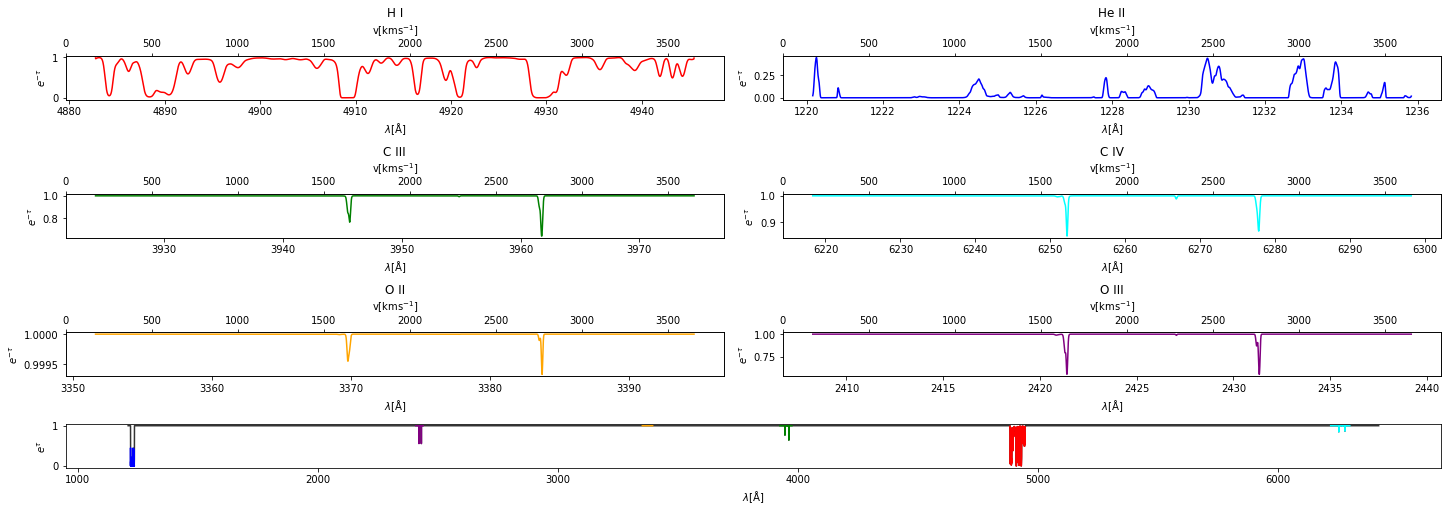

In [27]:
lambda_spectr = np.arange(lambdaz.min()-10,lambdaz.max()+200,0.012)
all_spectra   = np.zeros_like(lambda_spectr)
colours = ['red','blue','green','cyan','orange','purple']

fig = plt.figure(constrained_layout=True,figsize=(20, 7))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, :2])
ax4 = fig.add_subplot(gs[1, 2:])
ax5 = fig.add_subplot(gs[2, :2])
ax6 = fig.add_subplot(gs[2, 2:])
ax7 = fig.add_subplot(gs[-1, :])

axess = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

for axx,ion,cc in zip(axess,ions,colours):
    lambdaz_ion    = opticaldepth[ion]['lambda0'] * ( 1 + snap_red)
    
    
    od = opticaldepth[ion]['Optical depths']['Value']
    if ion == ('Hydrogen', 'H I'):
        od = opticaldepth['SimIons'][ion]['Optical depths']['Value']
    
    llinelambda_end   =  lambdaz_ion * np.exp(vel_arr/c_kms)
        
    axx.plot(llinelambda_end, np.exp(-od),c=cc)
    ax7.plot(llinelambda_end, np.exp(-od),c=cc)

    axx.set_title(ion[1])
    axx.set_xlabel(r'$\lambda [\mathrm{\AA}] $')
    axx.set_ylabel(r'$e^{-\tau}$')
    axx2 = axx.twiny()
    axx2.set_xlim(0,vel_arr.max())
    #axx2.plot(vel_arr,np.zeros_like(vel_arr))
    #axx2.cla()
    axx2.set_xlabel(r"$\mathrm{v[kms^{-1}]}$")
    print(ion,llinelambda_end.min(),llinelambda_end.max())
    all_spectra += Rebin(od,lambda_spectr,llinelambda_end)
ax7.plot(lambda_spectr,np.exp(-all_spectra),alpha=0.8,c='k',zorder=0)
ax7.set_xlabel(r'$\lambda [\mathrm{\AA}] $')
ax7.set_ylabel(r'$e^{\tau}$')

In [40]:
from SpecWizard_Elements import Elements

In [41]:
elements = Elements('./atom_dat.hdf5')

In [42]:
hyd_dat = elementes.ElementParameters(ElementNames=['Hydrogen'])

In [43]:
ly_lambda0 = hyd_dat['Hydrogen']['States']['H I']['Lines']['Lambda0']
ly_fvalues =  hyd_dat['Hydrogen']['States']['H I']['Lines']['f-value']

In [44]:
snap_red = snapshot.header['Cosmo']['Redshift']
lambdaz = np.array(ly_lambda0)  * ( 1 + snap_red)

In [45]:
lambda_spectr = np.arange(lambdaz.min()-200,lambdaz.max()+200,0.012)
all_spectra   = np.zeros_like(lambda_spectr)

In [48]:
from SpecWizard_Lines import Lines
lines = Lines( v_kms =vel_arr, box_kms=vel_arr.max())

In [49]:
no_dw = opticaldepth['SimIons'][('Hydrogen','H I')]['Optical depths']['Value']

In [53]:

lambda_spectr = np.arange((912*4)-100,lambdaz.max()+700,0.012)
lambda_spectr = np.arange(2000,lambdaz.max()+700,0.012)

all_spectra   = np.zeros_like(lambda_spectr)

velocity_start = 0
pixkms = 1.0
velocity_end   = vel_from_wv(lambda_spectr.max(),lambda_spectr.min(),c_kms)
velocity_npix  = int((velocity_end-velocity_start) * pixkms)
velocity_shor  = int(len(no_dw)) * pixkms
velocity_array = velocity_start + (np.arange(velocity_npix) * pixkms)

all_spectra = np.zeros_like(velocity_array)
lines = Lines( v_kms =velocity_array, box_kms=velocity_array.max())
lines_short = Lines( v_kms =vel_arr, box_kms=vel_arr.max())

ly_series = {}

for i in range(len(ly_lambda0)):
    lambdaz_ion    = ly_lambda0[i] * ( 1 + snap_red)
    
    if i ==0:
        
        #dw  = lines.convolvelorentz(no_dw)
        dw = no_dw
        llinelambda_end   =  lambdaz_ion * np.exp(vel_arr/c_kms)
        vel_offset        = vel_from_wv(lambdaz_ion,lambda_spectr.min(),c_kms=c_kms)
        vel_arr_line      = vel_offset+vel_arr
        hi                =  Rebin(no_dw,velocity_array,vel_arr_line)
        all_spectra       +=    hi
        all_spectra = lines.convolvelorentz(all_spectra)

        lambdaz_ion = (912 * ( 1 + snap_red))
        vel_offset        = vel_from_wv(lambdaz_ion,lambda_spectr.min(),c_kms=c_kms)
        vel_arr_line      = vel_offset+vel_arr
        dum_arr           = np.zeros_like(all_spectra)
        dum_arr          += Rebin(no_dw ,velocity_array,vel_arr_line) 
        limit = lines.convolveLymanLimit(dum_arr)
        #limit = lines_short.convolveLymanLimit(no_dw)
        ly_series[ly_lambda0[i]] = hi
        ly_series["dla"]   = all_spectra.copy()
        ly_series["limit"] = limit

        #all_spectra += dla
    
    else:
          
        tau_line = no_dw * ly_lambda0[i] *  ly_fvalues[i] / (ly_lambda0[0] *  ly_fvalues[0])
        vel_offset        = vel_from_wv(lambdaz_ion,lambda_spectr.min(),c_kms=c_kms)
        vel_arr_line      = vel_offset+vel_arr
        tau_long           = Rebin(tau_line,velocity_array,vel_arr_line)

        ly_series[ly_lambda0[i]] = tau_long
        all_spectra += tau_long


(180000.0, 307745.0)

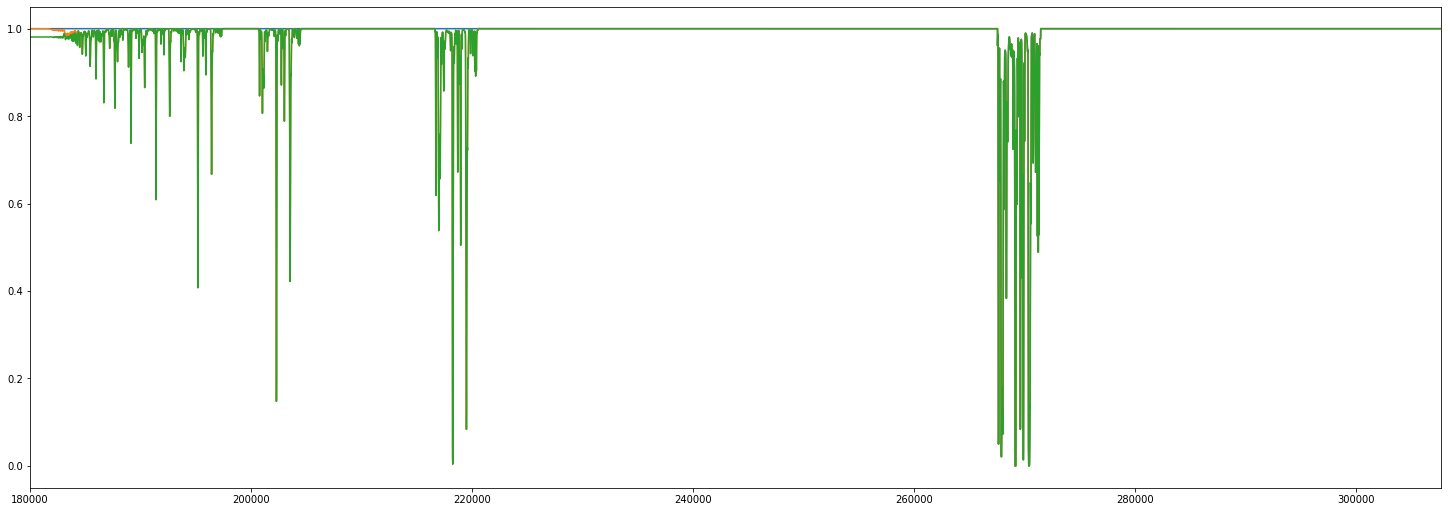

In [54]:
plt.figure(constrained_layout=True,figsize=(20, 7))

plt.plot(velocity_array,np.exp(-(ly_series[1215.6701]) ))
plt.plot(velocity_array,np.exp(-(all_spectra+0*ly_series['limit']) ))
plt.plot(velocity_array,np.exp(-(all_spectra+ly_series['limit']) ))
plt.xlim(180000,velocity_array.max())

In [17]:
def Rebin(spectrum, wavelong,waveshort):
    ''' rebin the function y(x) to the new bins xnew
     Interpolation is performed such that the mean of the function is conserved
     Input: 
       -spectrum: dictionary, containing
          -L:       linear extent of the wavelength range
          -wave:    wavelength or Hubble velocity
          -flux:    flux
       -wave:       new wavelength or Hubble velocioty to rebin to 
       '''
    # determine pixel size
    L    = waveshort.max() #spectrum["L"]
    npix = len(spectrum) #spectrum["npix"]
    pix  = L/npix
    x0   = np.arange(npix) * pix
    vHubble = waveshort
    dx = vHubble[1:] -vHubble[0:-1]
    dx = np.concatenate([dx, [L - x0[-1]]])
    #
    xR = np.copy(vHubble) + dx  # right side of pixel

    # cumulative sum of the function y0(x0)
    f = np.cumsum(spectrum * dx)

    # new pixels
    dxnew = wavelong[1:] - wavelong[0:-1]  # size of pixels
    dxnew = np.concatenate([dxnew, [L - wavelong[-1]]])
    xnewR = np.copy(wavelong) + dxnew  # right side of pixels

    # interpolation function
    finterp = interp1d(xR,
                       f,
                       kind='linear',
                       bounds_error=False,
                       fill_value=(0, f[-1]))
    fnew = finterp(xnewR)

    # rebinned value
    fbinned = np.concatenate([[0], fnew])
    ynew = (fbinned[1:] - fbinned[0:-1]) / dxnew
    #
    newspectrum         = spectrum.copy()
    #newspectrum["wave"] = np.copy(wave)
    #newspectrum["flux"] = ynew
    return ynew

In [52]:
def vel_from_wv(lambda_f,lambda_min,c_kms=1):
    '''
    Calculates velocity [km/s] from wavelength range
    '''
    return np.log(lambda_f/lambda_min) * c_kms